In [1]:
import importlib
import pre_processing as prep
import sqlite3
import json
import datetime
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
import matplotlib.dates as mdates

conn = prep.connect_db("numero_data.sqlite")

# Load raw json
df_raw = prep.load_raw_sales(conn)
df_sales = prep.flatten_sales_json(df_raw)
prep.save_df_to_csv(df_sales, "sales_processed.csv")

# Dataset
df_meta, df_titles = prep.load_metadata_and_titles(conn) 
df = prep.join_sales_metadata(df_sales, df_meta, df_titles)

Loaded 100 raw film records.


Flattening sales JSON: 100%|██████████| 100/100 [00:00<00:00, 148.49it/s]


Successfully processed 65947 rows.


# VISUALIZATION

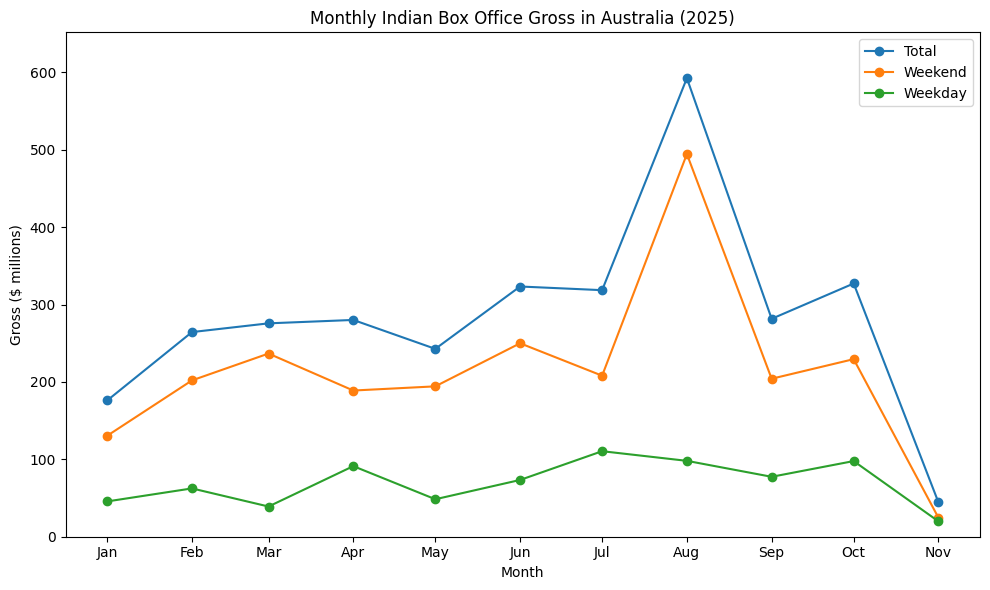

In [2]:
# Monthly totals
df["weekend_gross_component"] = df["gross_today"].where(df["is_weekend_numero"], 0)

monthly = (
    df.groupby("month", as_index=False)
      .agg(total_gross=("gross_today", "sum"),
          weekend_gross=("weekend_gross_component", "sum"),
      )
)

monthly["weekday_gross"] = monthly["total_gross"] - monthly["weekend_gross"]
monthly = monthly.sort_values("month")

total_M   = monthly["total_gross"]   / 1e6
weekend_M = monthly["weekend_gross"] / 1e6
weekday_M = monthly["weekday_gross"] / 1e6

plt.figure(figsize=(10, 6))
plt.plot(monthly["month"], total_M,   marker="o", label="Total")
plt.plot(monthly["month"], weekend_M, marker="o", label="Weekend")
plt.plot(monthly["month"], weekday_M, marker="o", label="Weekday")

month_labels = monthly["month"].dt.strftime("%b") 
plt.xticks(monthly["month"], month_labels, rotation=0)

plt.ylabel("Gross ($ millions)")
plt.ylim(0, total_M.max() * 1.1) 
plt.ticklabel_format(style="plain", axis="y") 

plt.xlabel("Month")
plt.title("Monthly Indian Box Office Gross in Australia (2025)")
plt.legend()
plt.tight_layout()
plt.show()

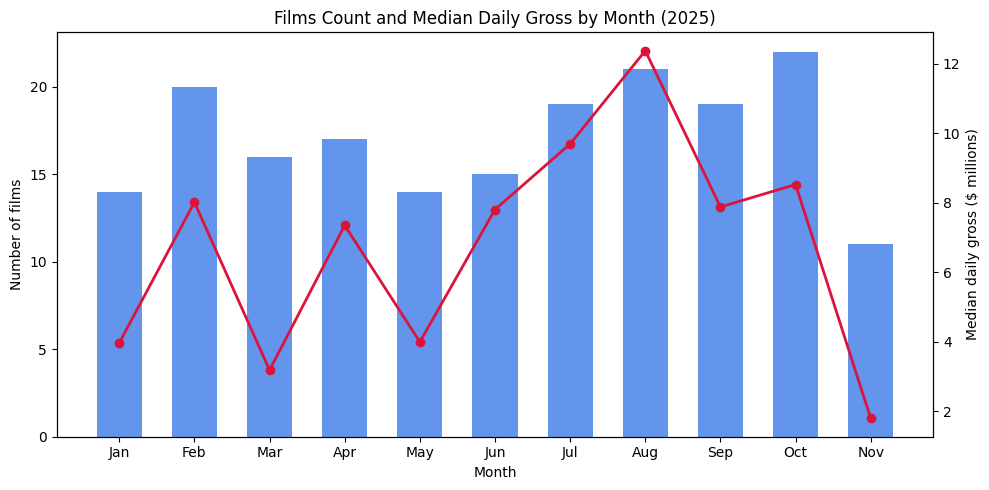

In [3]:
# Films count with median daily gross by month
films_per_month = (
    df.groupby("month")["title"]
      .nunique()
      .reset_index(name="num_films")
      .sort_values("month")
)

daily_month = (
    df.groupby(["month", "actual_sales_date"], as_index=False)["gross_today"]
      .sum()
      .rename(columns={"gross_today": "daily_gross"})
)

median_gross_month = (
    daily_month.groupby("month", as_index=False)["daily_gross"]
      .median()
      .rename(columns={"daily_gross": "median_daily_gross"})
)

month_stats = films_per_month.merge(median_gross_month, on="month", how="left")
month_stats = month_stats.sort_values("month")

month_labels = month_stats["month"].dt.strftime("%b")
x_pos = np.arange(len(month_stats))

num_films = month_stats["num_films"].values
median_gross_M = (month_stats["median_daily_gross"] / 1e6).values


fig, ax1 = plt.subplots(figsize=(10, 5))
# Bar: total number of films
bar_width = 0.6
ax1.bar(x_pos, num_films, width=bar_width, color="cornflowerblue")
ax1.set_xlabel("Month")
ax1.set_ylabel("Number of films")
ax1.set_xticks(x_pos)
ax1.set_xticklabels(month_labels)

# Line: median daily gross
ax2 = ax1.twinx()
ax2.plot(x_pos, median_gross_M, marker="o", color="crimson", linewidth=2,
         label="Median daily gross ($M)")
ax2.set_ylabel("Median daily gross ($ millions)")

plt.title("Films Count and Median Daily Gross by Month (2025)")
plt.tight_layout()
plt.show()


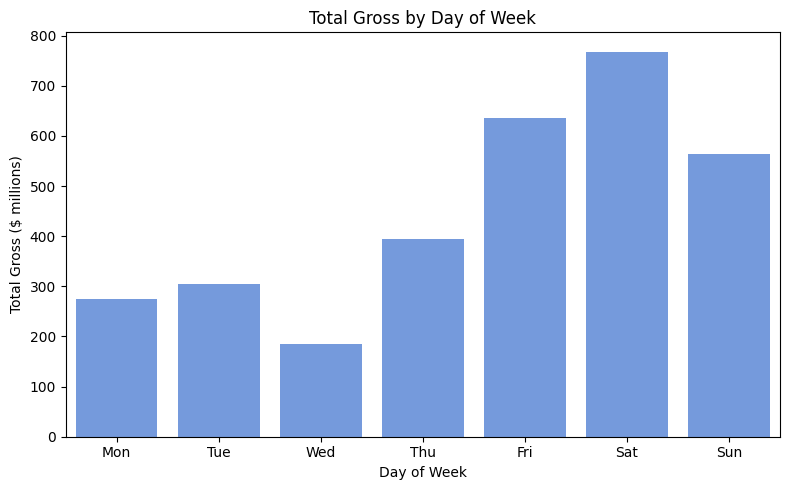

In [4]:
dow_labels = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]

dow_gross = (
    df.groupby("dow")["gross_today"]
      .sum()
      .reindex(range(7))      
      .reset_index(name="total_gross")
)
dow_gross["total_gross"] = dow_gross["total_gross"] / 1e6

plt.figure(figsize=(8, 5))
sns.barplot(data=dow_gross, x="dow", y="total_gross", color="cornflowerblue")
plt.xticks(ticks=range(7), labels=dow_labels)
plt.ylabel("Total Gross ($ millions)")
plt.xlabel("Day of Week")
plt.title("Total Gross by Day of Week")
plt.tight_layout()
plt.show()

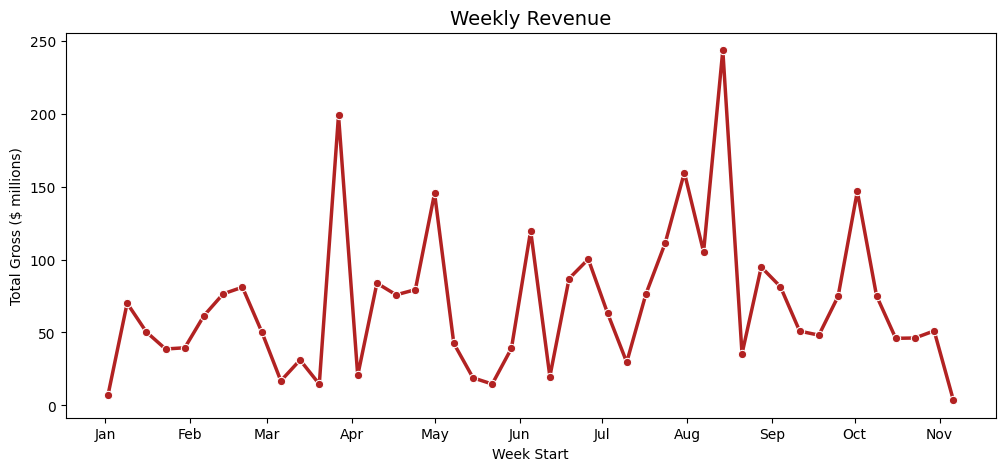

In [9]:
# Weekly trend
weekly_gross = df.groupby('week_start_date')['gross_today'].sum().reset_index()

plt.figure(figsize=(12, 5))
ax = sns.lineplot(data=weekly_gross, x='week_start_date', y='gross_today', marker='o', color='#b22222', linewidth=2.5)

# Format y-axis
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x/1e6:.0f}'))

# Format x-axis
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

plt.title("Weekly Revenue", fontsize=14)
plt.ylabel("Total Gross ($ millions)")
plt.xlabel("Week Start")
plt.show()

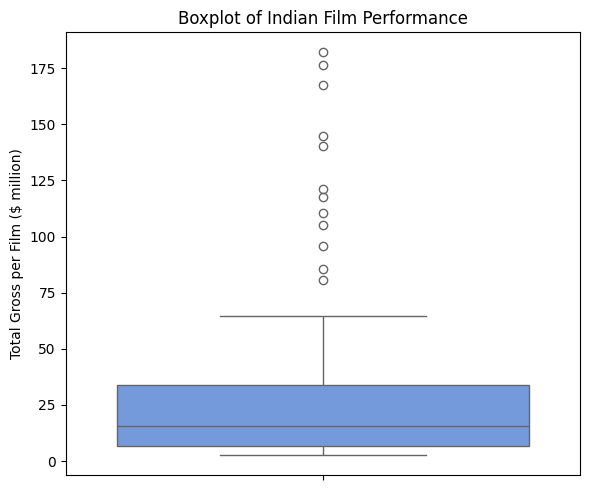

In [10]:
# Boxplot
film_gross = (df.groupby("title", as_index=False)["gross_today"].sum()
      .rename(columns={"gross_today": "total_gross"}))
film_gross["total_gross"] = film_gross["total_gross"] /1e6
plt.figure(figsize=(6, 5))
sns.boxplot(data=film_gross, y="total_gross", color="cornflowerblue")
plt.ylabel("Total Gross per Film ($ million)")
plt.title("Boxplot of Indian Film Performance")
plt.tight_layout()
plt.show()

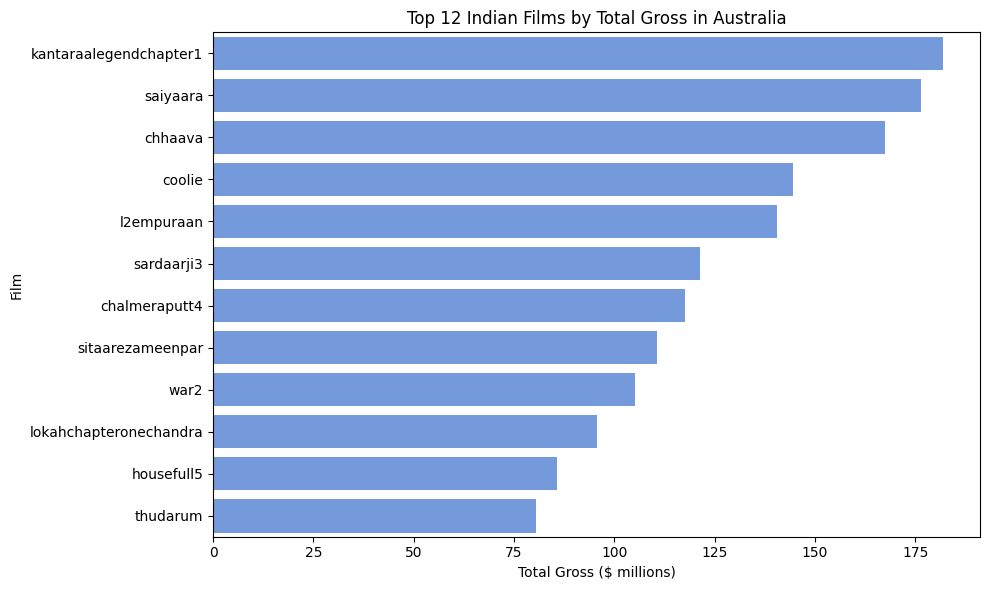

In [11]:
# Top performing films (by revenue)
film_perf = (
    df.groupby("title", as_index=False)["gross_today"].sum().rename(columns={"gross_today": "total_gross"})
      .sort_values("total_gross", ascending=False).head(12))

# Total Indian box office
film_perf["total_gross"] = film_perf["total_gross"] / 1e6
grand_total = film_gross["total_gross"].sum()
film_perf["percent_of_total"] = (film_perf["total_gross"] / grand_total) *100

plt.figure(figsize=(10, 6))
sns.barplot(data=film_perf, y="title", x="total_gross", color="cornflowerblue")
plt.title("Top 12 Indian Films by Total Gross in Australia")
plt.xlabel("Total Gross ($ millions)")
plt.ylabel("Film")
plt.tight_layout()
plt.show()

In [15]:
top_12_titles = film_perf['title'].tolist()
top_films_data = df[df['title'].isin(top_12_titles)]
film_dates = (
    top_films_data.groupby('title')['actual_sales_date']
    .agg(['min', 'max'])
    .reset_index()
    .rename(columns={'min': 'release_date', 'max': 'last_showing'})
)
film_perf_with_dates = film_perf.merge(film_dates, on='title', how='left')
display(film_perf_with_dates[['title', 'total_gross', 'release_date', 'last_showing', 'percent_of_total']])

,title,total_gross,release_date,last_showing,percent_of_total
0,kantaraalegendchapter1,182.044184,2025-10-02,2025-11-12,5.821928
1,saiyaara,176.392024,2025-07-17,2025-09-10,5.641167
2,chhaava,167.509548,2025-02-13,2025-04-02,5.357098
3,coolie,144.641071,2025-08-14,2025-09-03,4.625744
4,l2empuraan,140.466294,2025-03-27,2025-04-16,4.492231
5,sardaarji3,121.291180,2025-06-26,2025-07-30,3.878995
6,chalmeraputt4,117.511756,2025-07-31,2025-09-10,3.758126
7,sitaarezameenpar,110.568851,2025-06-19,2025-08-20,3.536086
8,war2,105.243152,2025-08-14,2025-09-10,3.365765
9,lokahchapteronechandra,95.631415,2025-08-28,2025-10-08,3.058374


In [16]:
# Excluding top 12
top_12_ids = df.groupby('numero_film_id')['gross_today'].sum().sort_values(ascending=False).head(12).index.tolist()
sales_mid_market = df[~df['numero_film_id'].isin(top_12_ids)]

In [17]:
total_market_gross = df['gross_today'].sum()
mid_market_gross = sales_mid_market['gross_today'].sum()
drop_off = (1 - (mid_market_gross / total_market_gross)) * 100

print(f"Without Top 12 films, we removed {drop_off:.1f}% of the total revenue.")
print(f"Original Market Size: ${total_market_gross:,.0f}")
print(f"Remaining Market Size: ${mid_market_gross:,.0f}")

Without Top 12 films, we removed 48.9% of the total revenue.
Original Market Size: $3,126,871,244
Remaining Market Size: $1,599,215,276


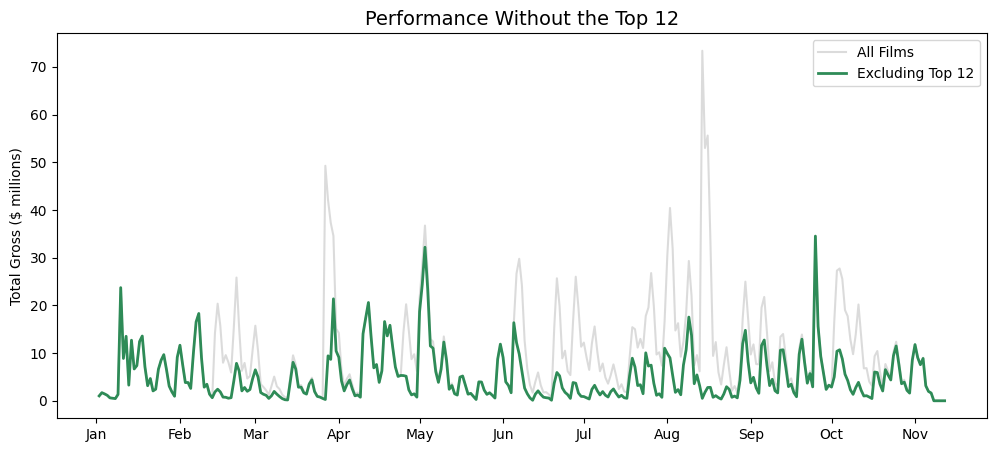

In [18]:
# Daily aggregates
daily_total = df.groupby('actual_sales_date')['gross_today'].sum().reset_index()
daily_excl_outliers = df[~df['numero_film_id'].isin(top_12_ids)].groupby('actual_sales_date')['gross_today'].sum().reset_index()

daily_total['gross_today'] = daily_total['gross_today']/1e6
daily_excl_outliers['gross_today'] = daily_excl_outliers['gross_today']/1e6

plt.figure(figsize=(12, 5))
# Plot all films
plt.plot(daily_total['actual_sales_date'], daily_total['gross_today'], label='All Films', color='lightgray', alpha=0.8)
# Plot without top 12
plt.plot(daily_excl_outliers['actual_sales_date'], daily_excl_outliers['gross_today'], label='Excluding Top 12', color='#2e8b57', linewidth=2)

month_labels = monthly["month"].dt.strftime("%b") 
plt.xticks(monthly["month"], month_labels, rotation=0)

plt.title("Performance Without the Top 12", fontsize=14)
plt.ylabel("Total Gross ($ millions)")
plt.legend()
plt.show()

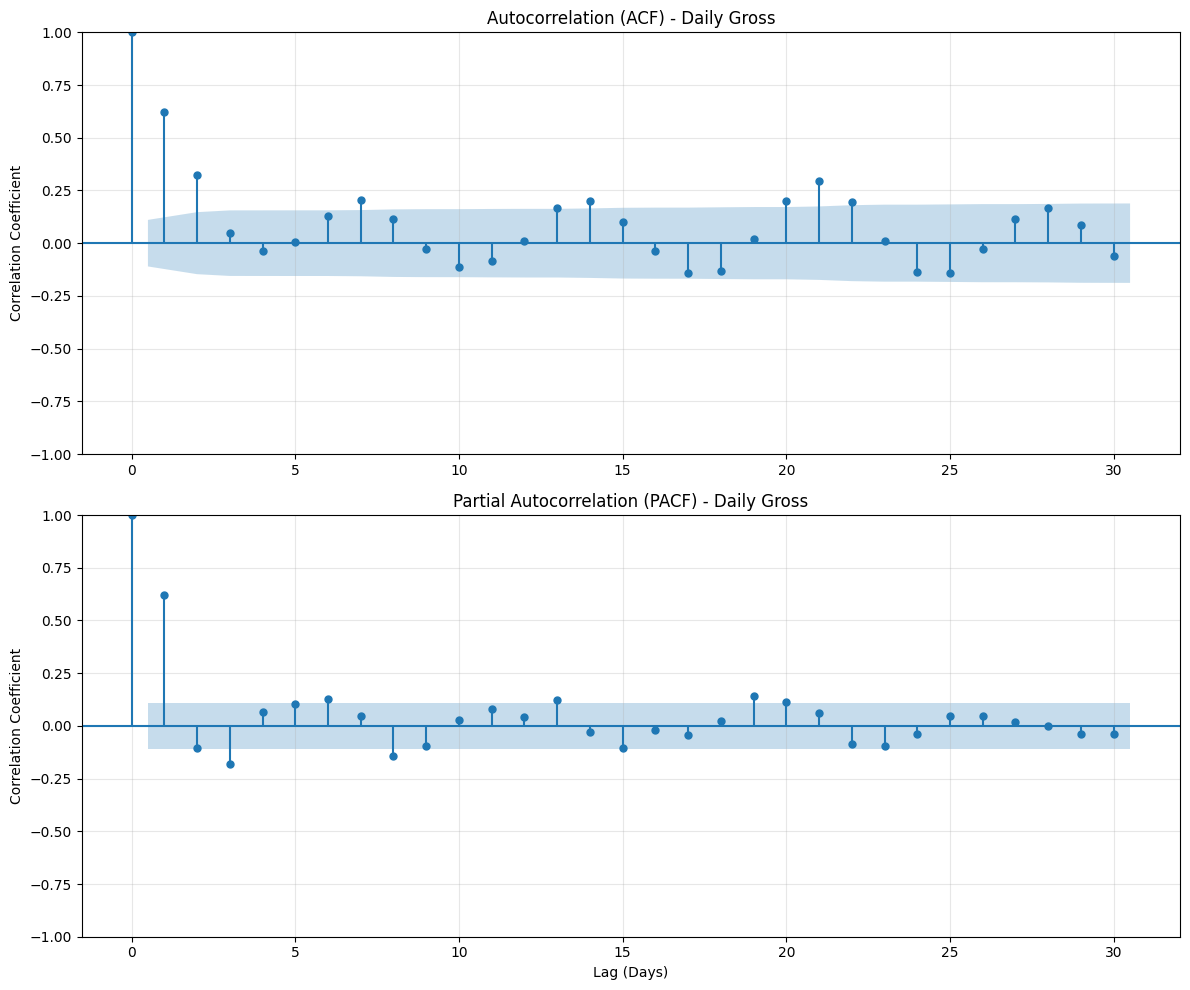

In [19]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

daily_excl_outliers['actual_sales_date'] = pd.to_datetime(daily_excl_outliers['actual_sales_date'])
ts_data = daily_excl_outliers.set_index('actual_sales_date')['gross_today']
ts_data = ts_data.sort_index()

fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# ACF
plot_acf(ts_data, lags=30, ax=axes[0], title='Autocorrelation (ACF) - Daily Gross')
axes[0].set_ylabel('Correlation Coefficient')
axes[0].grid(True, alpha=0.3)

# PACF
plot_pacf(ts_data, lags=30, ax=axes[1], title='Partial Autocorrelation (PACF) - Daily Gross')
axes[1].set_xlabel('Lag (Days)')
axes[1].set_ylabel('Correlation Coefficient')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

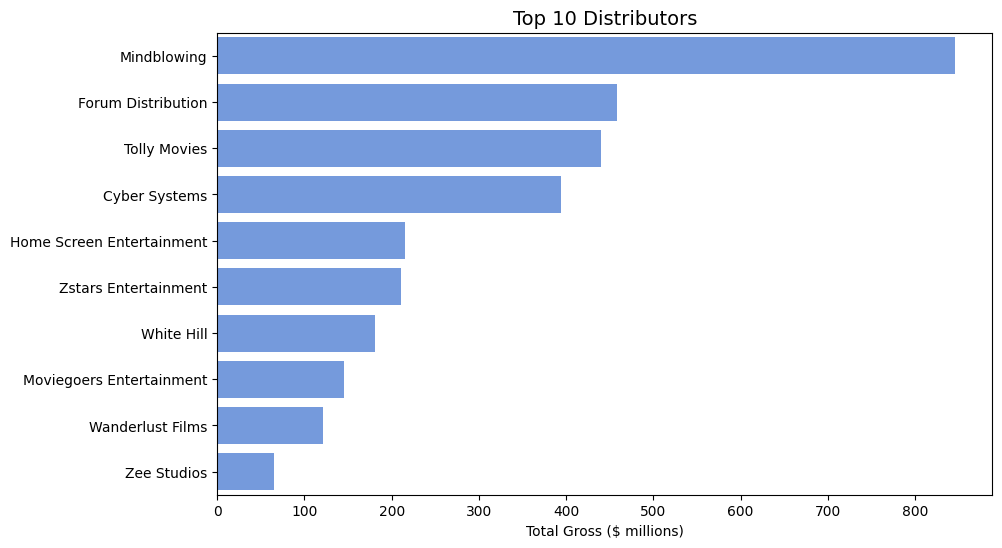

In [20]:
# Top 10 Distributors
dist_market_share = df.groupby('distributor')['gross_today'].sum().reset_index()
dist_market_share = dist_market_share.sort_values('gross_today', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=dist_market_share.head(10), x='gross_today', y='distributor',color='cornflowerblue')
plt.title("Top 10 Distributors", fontsize=14)
plt.xlabel("Total Gross ($ millions)")
plt.ylabel(None)
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x/1e6:.0f}'))
plt.show()

In [21]:
# Total gross and film count per distributor
dist_stats = (
    df.groupby(["distributor", "title"], as_index=False)["gross_today"]
      .sum()
      .rename(columns={"gross_today": "film_gross"})
      .groupby("distributor", as_index=False)
      .agg(
          total_gross=("film_gross", "sum"),
          num_films=("title", "nunique"),
          avg_gross_per_film=("film_gross", "mean")
      )
      .sort_values("avg_gross_per_film", ascending=False)
)

dist_stats["avg_gross_per_film"] = dist_stats["avg_gross_per_film"] / 1e6
dist_stats_top = dist_stats.head(10)
dist_stats["total_gross"] = dist_stats["total_gross"] / 1e6
grand_total = dist_stats["total_gross"].sum()
dist_stats_top["percent_of_total"] = (dist_stats["total_gross"] / grand_total) *100

display(dist_stats_top[["distributor", "total_gross", "percent_of_total", "avg_gross_per_film"]]
          .round({"total_gross": 2, "percent_of_total": 2, "avg_gross_per_film":2}))

,distributor,total_gross,percent_of_total,avg_gross_per_film
13,Zstars Entertainment,210804260.0,6.74,52.70
3,Mindblowing,846236394.0,27.06,49.78
11,White Hill,181335733.0,5.80,45.33
0,Cyber Systems,394466536.0,12.62,35.86
6,S J Cinemas,32468671.0,1.04,32.47
1,Forum Distribution,458183666.0,14.65,30.55
10,Wanderlust Films,120813485.0,3.86,30.20
8,Tolly Movies,439568247.0,14.06,27.47
4,Moviegoers Entertainment,145331031.0,4.65,24.22
2,Home Screen Entertainment,215413384.0,6.89,17.95


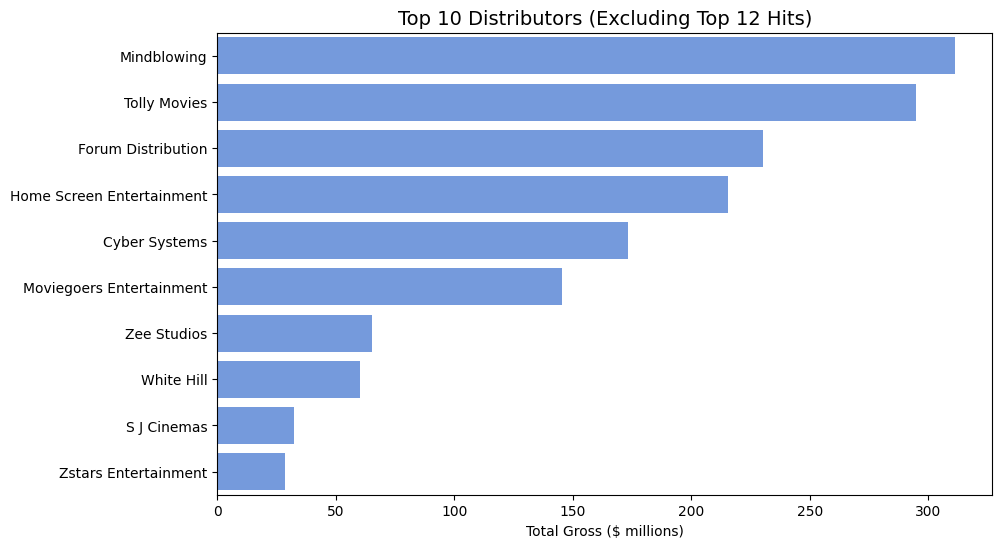

In [22]:
sales_mid_market = df[~df['numero_film_id'].isin(top_12_ids)]
dist_mid_share = sales_mid_market.groupby('distributor')['gross_today'].sum().reset_index()
dist_mid_share = dist_mid_share.sort_values('gross_today', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(data=dist_mid_share, x='gross_today', y='distributor', color='cornflowerblue')

plt.title('Top 10 Distributors (Excluding Top 12 Hits)', fontsize=14)
plt.xlabel('Total Gross ($ millions)')
plt.ylabel(None)

import matplotlib.ticker as ticker
ax = plt.gca()
if dist_mid_share['gross_today'].max() > 1e6:
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x/1e6:.0f}'))
else:
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x/1e3:.0f}'))

plt.show()

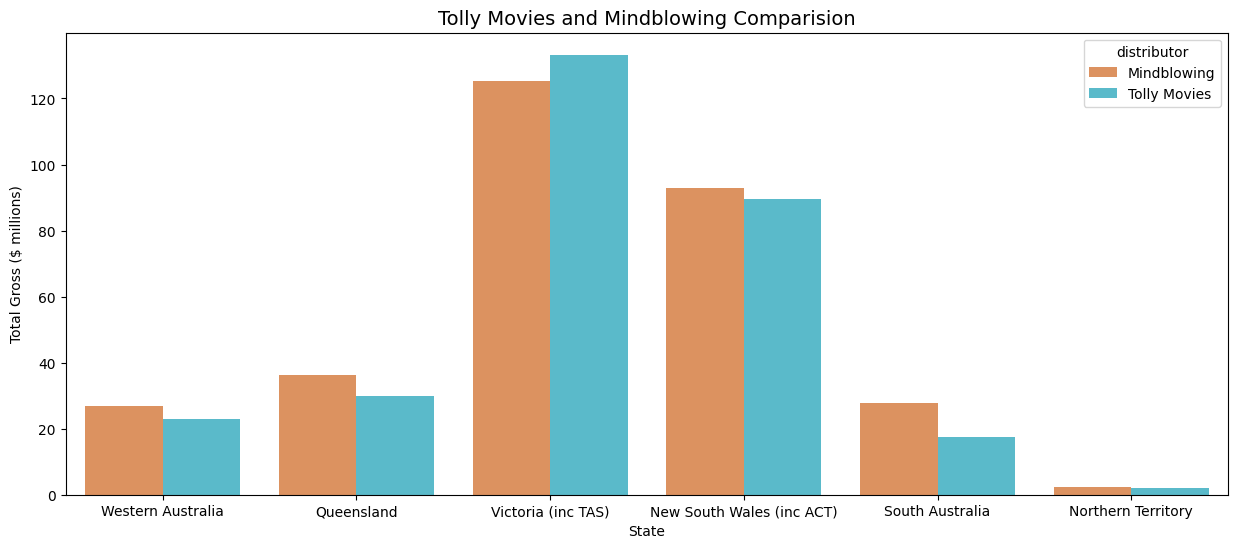

In [23]:
# Check between Tolly Movies and Mindblowing
dist_geo = sales_mid_market[sales_mid_market['distributor'].isin(['Tolly Movies', 'Mindblowing'])]
dist_geo['gross_today'] = dist_geo['gross_today']/1e6

plt.figure(figsize=(15, 6))
sns.barplot(
    data=dist_geo, 
    x='state', 
    y='gross_today', 
    hue='distributor', 
    estimator=sum, 
    errorbar=None,
    palette={'Tolly Movies': "#47c7dd", 'Mindblowing': "#f18e4b"}
)
plt.title("Tolly Movies and Mindblowing Comparision", fontsize=14)
plt.ylabel('Total Gross ($ millions)')
plt.xlabel('State')
plt.show()

In [24]:
# Location
cinema_stats = df.groupby(['state','city','theatre_name' ]).agg(
    total_gross=('gross_today', 'sum'),
    days_active=('actual_sales_date', 'nunique'),
    avg_daily_gross=('gross_today', 'mean')
).reset_index()
# cinema_stats = cinema_stats[cinema_stats['total_gross'] > 1000]
cinema_stats_sort = cinema_stats.sort_values('total_gross', ascending=False)
grand_total = cinema_stats_sort['total_gross'].sum()
cinema_stats_sort['percent_share'] = (cinema_stats_sort['total_gross'] / grand_total) * 100

display(
    cinema_stats_sort.head(15).style.format({
        'total_gross': '${:,.0f}',
        'avg_daily_gross': '${:,.0f}',
        'percent_share': '{:.2f}%'
    })
)

,state,city,theatre_name,total_gross,days_active,avg_daily_gross,percent_share
68,New South Wales (inc ACT),West and Blue Mountains,Blacktown,"$272,377,817",315,"$216,689",8.71%
202,Victoria (inc TAS),West Melbourne,Sunshine,"$209,822,774",315,"$104,545",6.71%
54,New South Wales (inc ACT),Parramatta & Ryde,Parramatta,"$186,267,643",315,"$175,890",5.96%
204,Victoria (inc TAS),West Melbourne,Werribee,"$130,211,836",315,"$104,840",4.16%
216,Western Australia,Perth - South East,Carousel,"$127,762,193",315,"$190,690",4.09%
190,Victoria (inc TAS),South East Melbourne,Chadstone,"$120,959,042",308,"$192,917",3.87%
92,Queensland,Brisbane - South,Garden City Mt. Gravatt,"$117,022,392",315,"$94,832",3.74%
192,Victoria (inc TAS),South East Melbourne,Fountain Gate,"$116,249,483",315,"$128,311",3.72%
137,South Australia,Adelaide - West,Hoyts Arndale,"$100,301,966",315,"$114,239",3.21%
147,Victoria (inc TAS),Central Inner Melbourne,Docklands,"$87,963,587",308,"$124,418",2.81%


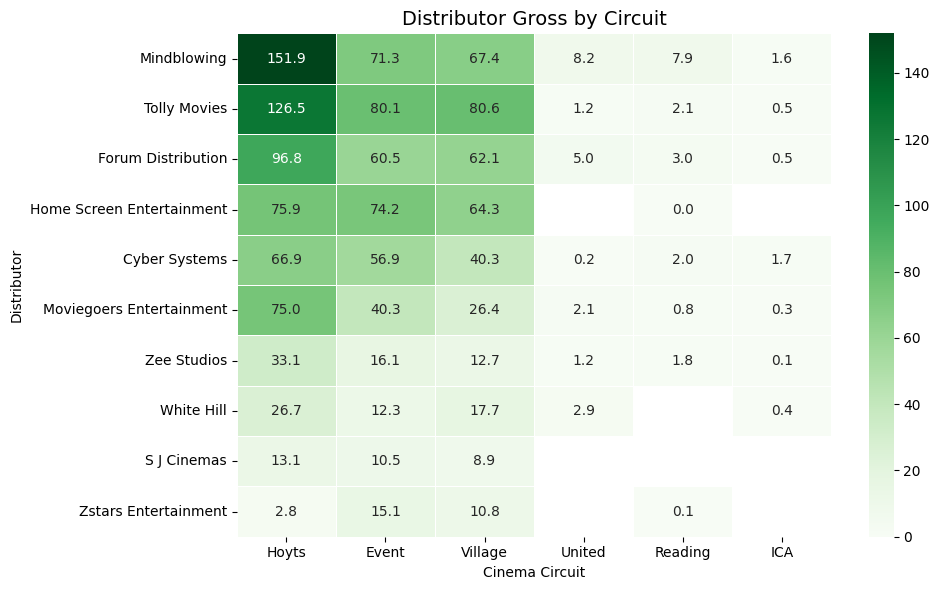

In [25]:
# Distributor by Circuit
dist_circuit = sales_mid_market.groupby(['distributor', 'circuit_name'])['gross_today'].sum().reset_index()
dist_circuit['gross_today'] = dist_circuit['gross_today']/1e6

# Filter for Top Distributors and Top Circuits
top_dists = dist_circuit.groupby('distributor')['gross_today'].sum().nlargest(10).index
top_circuits = dist_circuit.groupby('circuit_name')['gross_today'].sum().nlargest(6).index

filtered_map = dist_circuit[
    dist_circuit['distributor'].isin(top_dists) & 
    dist_circuit['circuit_name'].isin(top_circuits)]

# Matrix
pivot_map = filtered_map.pivot(index='distributor', columns='circuit_name', values='gross_today')
dist_totals = pivot_map.sum(axis=1).sort_values(ascending=False).index
circuit_totals = pivot_map.sum(axis=0).sort_values(ascending=False).index
pivot_map_sorted = pivot_map.loc[dist_totals, circuit_totals]

# Plot
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_map_sorted, annot=True, fmt=',.1f', cmap='Greens',linewidths=.5)
plt.title('Distributor Gross by Circuit', fontsize=14)
plt.ylabel('Distributor')
plt.xlabel('Cinema Circuit')
plt.tight_layout()
plt.show()